In [1]:
%load_ext autoreload
%autoreload 2
import sys
# do this to be able to import the custom python scripts
sys.path.insert(1, "../../python_scripts")
import os

import dm_utils
import dm_plots
import dm_file_checker

import numpy as np
import pandas as pd
from tqdm import tqdm

import json
import csv

## Get Appropriate Filepaths

In [2]:
saved_files_path = "../../saved_files"
fusion_output_path = os.path.join(saved_files_path, "fusion/fusion_output.csv")

rl_task_names = [folder for folder in os.listdir(saved_files_path) if "rl-" in folder] 

print(rl_task_names)

['rl-febrl4a_febrl4b']


## Re-cluster all scored links across datasets

In [3]:
%%time
scored_pairs, all_records = dm_utils.get_all_rl_results(rl_task_names, saved_files_path)

probs, threshold = dm_utils.get_fusion_probs_and_threshold(scored_pairs)
print(threshold)

Getting mapped record links from rl-febrl4a_febrl4b
Maximum expected recall and precision
recall: 100.00%
precision: 99.76%
With threshold: 61.07%
0.61067396
CPU times: user 271 ms, sys: 24 ms, total: 295 ms
Wall time: 402 ms


../../python_scripts/dm_utils.py:1181: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype = np.dtype([("pairs", id_type, 2),


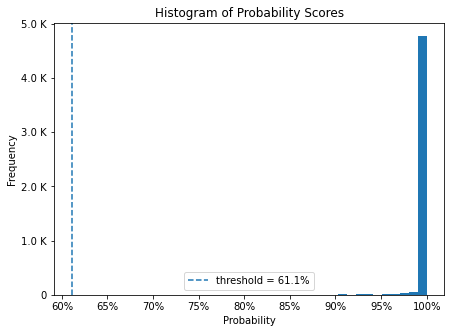

In [4]:
dm_plots.plot_prob_histogram(probs,threshold)

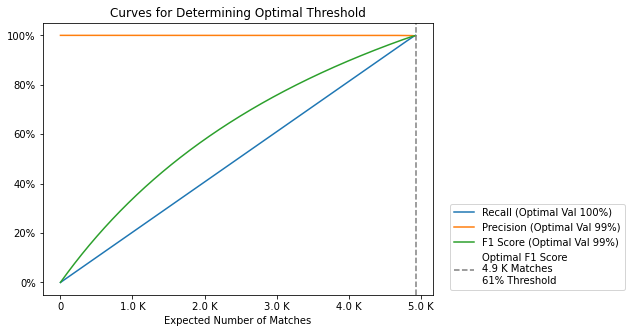

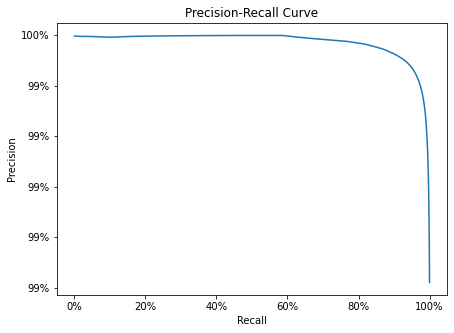

In [5]:
dm_plots.plot_threshold_finder_curves(probs,threshold,recall_weight = 1)

In [6]:
mapped_records = dm_utils.map_cluster_fusion_ids(scored_pairs, all_records, threshold)

1065it [00:00, 10648.06it/s]

Mapping cluster ids...


4929it [00:00, 18935.61it/s]
100%|██████████| 142/142 [00:00<00:00, 56326.00it/s]

Mapping solo record ids...


In [7]:
# delete the memory mapped file so it won't clog the disk
temp_filename = scored_pairs.filename
del scored_pairs
os.remove(temp_filename)

In [8]:
mapped_records["dataset name"] = mapped_records["record id"].apply(lambda x: x.split("-")[0])
mapped_records.head()

,record id,cluster id,confidence score,cluster type,dataset name
0,febrl4a-rec-4100-org,fs-1,0.999991,link,febrl4a
1,febrl4b-rec-4100-dup-0,fs-1,0.999991,link,febrl4b
2,febrl4a-rec-3002-org,fs-2,0.999989,link,febrl4a
3,febrl4b-rec-3002-dup-0,fs-2,0.999989,link,febrl4b
4,febrl4a-rec-4737-org,fs-3,0.999989,link,febrl4a


In [9]:
mapped_records = mapped_records.rename(columns = {"record id":"cluster id","cluster id":"fusion id", 
                                        "confidence score":"rl confidence score", "cluster type":"rl cluster type"})
mapped_records = mapped_records.loc[:,["fusion id", "cluster id", "rl confidence score", "rl cluster type", "dataset name"]]
mapped_records.head()

,fusion id,cluster id,rl confidence score,rl cluster type,dataset name
0,fs-1,febrl4a-rec-4100-org,0.999991,link,febrl4a
1,fs-1,febrl4b-rec-4100-dup-0,0.999991,link,febrl4b
2,fs-2,febrl4a-rec-3002-org,0.999989,link,febrl4a
3,fs-2,febrl4b-rec-3002-dup-0,0.999989,link,febrl4b
4,fs-3,febrl4a-rec-4737-org,0.999989,link,febrl4a


## Summary Report for Comparing with Record Linkage Results

- The number of linked pairs from fusion are expected to vary from the record linkage results
    - The number of links may decrease due to the re-setting of the threshold in the clustering step done above
    - Some customers in the same database that belong to different clusters may be put under the same fusion ID because they were found to be linked to the same records in other databases.

In [10]:
for rl_task in rl_task_names:
    data_name_1, data_name_2 = rl_task.split("-")[1].split("_")
    
    cust_id_1 = mapped_records.loc[(mapped_records["dataset name"] == data_name_1),"cluster id"].tolist()
    cust_id_1 = set(cust_id_1)
    cust_id_2 = mapped_records.loc[(mapped_records["dataset name"] == data_name_2),"cluster id"].tolist()
    cust_id_2 = set(cust_id_2)
    
    cust_id_1_2 = cust_id_1.intersection(cust_id_2)
    
    print("For {} and {}, there are {:,} and {:,} (deduped) customers, respectively".format(data_name_1, data_name_2, 
                                                                                 len(cust_id_1), len(cust_id_2)))
    
    print("There are {:,} customers that both have {} and {}".format(len(cust_id_1_2), data_name_1, data_name_2))

For febrl4a and febrl4b, there are 5,000 and 5,000 (deduped) customers, respectively
There are 0 customers that both have febrl4a and febrl4b


## Map the fusion IDs all the way back to the original record IDs 
- Join the fusion table with a consolidated dedup table 

In [11]:
all_dedup_mapped_records = dm_utils.get_all_dedup_results(rl_task_names, saved_files_path)
all_dedup_mapped_records.head()

""


In [12]:
if all_dedup_mapped_records.empty:
    mapped_records = mapped_records.rename(columns = {"cluster id":"record id"})
    mapped_records["record id"] = mapped_records.apply(lambda row: row["record id"]\
                                                        .replace("{}-".format(row["dataset name"]), ""),
                                                       axis = 1)
else:
    mapped_records = pd.merge(left = mapped_records, right = all_dedup_mapped_records, 
                              on = "cluster id", how = "outer")

mapped_records.head()

,fusion id,record id,rl confidence score,rl cluster type,dataset name
0,fs-1,rec-4100-org,0.999991,link,febrl4a
1,fs-1,rec-4100-dup-0,0.999991,link,febrl4b
2,fs-2,rec-3002-org,0.999989,link,febrl4a
3,fs-2,rec-3002-dup-0,0.999989,link,febrl4b
4,fs-3,rec-4737-org,0.999989,link,febrl4a


## Summary Report with Unduplicated Record IDs
- Previous summary report is using the cluster IDs. This summary report is for the unduplicated (original) IDs

In [13]:
for rl_task in rl_task_names:
    data_name_1, data_name_2 = rl_task.split("-")[1].split("_")
    
    cust_id_1 = mapped_records.loc[(mapped_records["dataset name"] == data_name_1),"record id"].tolist()
    cust_id_1 = set(cust_id_1)
    cust_id_2 = mapped_records.loc[(mapped_records["dataset name"] == data_name_2),"record id"].tolist()
    cust_id_2 = set(cust_id_2)
    
    cust_id_1_2 = cust_id_1.intersection(cust_id_2)
    
    print("For {} and {}, there are {:,} and {:,} (undeduped) customers respectively".format(data_name_1, data_name_2, 
                                                                                 len(cust_id_1), len(cust_id_2)))
    
    print("There are {:,} customers that both have {} and {}".format(len(cust_id_1_2), data_name_1, data_name_2))

For febrl4a and febrl4b, there are 5,000 and 5,000 (undeduped) customers respectively
There are 0 customers that both have febrl4a and febrl4b


## Write out Fusion Output to File

In [14]:
# checking file before writing out

assert mapped_records["fusion id"].isnull().sum() == 0, "There must not be a null fusion ID!"
assert mapped_records["record id"].isnull().sum() == 0, "There must not be a null record ID!"

In [15]:
mapped_records.to_csv(fusion_output_path, index = False, quoting = csv.QUOTE_ALL, encoding = "utf-8")